## Define Transfer Learning Model (w/ VGG16)

### Setup virtual environment

In [ ]:
!pip install --upgrade pip
!pip install --upgrade tensorflow
!pip install ipykernel
# setup python kernel to the virtual enviornment
!python -m ipykernel install --user --name venv --display-name "Python (venv)"

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os, tempfile

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Define Train, Validation and Test data

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory

train_dir = './data_kaggle_train/'
valid_dir = './data_kaggle_valid/'
test_dir = './data_kaggle_test/'

batch_size = 32
target_size = (224,224)

train_gen = ImageDataGenerator(rescale=1.0/255.0,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)

valid_gen = ImageDataGenerator(rescale=1.0/255.0)

test_gen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_gen.flow_from_directory(train_dir, 
                                              batch_size=batch_size, 
                                              class_mode='binary',
                                              shuffle=True,
                                              target_size=target_size)

valid_generator = valid_gen.flow_from_directory(valid_dir, 
                                              batch_size=batch_size, 
                                              class_mode='binary',
                                              shuffle=False,
                                              target_size=target_size)

test_generator = test_gen.flow_from_directory(test_dir, 
                                              batch_size=1, 
                                              class_mode='binary',
                                              shuffle=False,
                                              target_size=target_size)

Found 1977 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


## Define the Model and Metrics

In [17]:
from keras.optimizers import SGD
from keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
from keras.initializers import Constant
from keras.applications import VGG16
from keras.models import Model

epochs = 50
kernel_size = (3,3)
pool_size = (2,2)
input_shape = (224,224,3)
n_filters = 32


METRICS = [
    TruePositives(name='tp'),
    FalsePositives(name='fp'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn'), 
    BinaryAccuracy(name='accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics= METRICS, output_bias= None):
    # use VGG16
    model= VGG16(weights='imagenet', include_top= False, input_shape= input_shape)
    # define model to use on top of VGG16
    if output_bias is not None:
        output_bias = Constant(output_bias)
    top_model = Sequential([
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid', bias_initializer=output_bias)
    ])
    # build Model
    model = Model(inputs= model.input, outputs= top_model(model.output))
    # note that it is necessary to start with a fully-trained
    # classifier, including the top classifier,
    # in order to successfully do fine-tuning
    top_model.load_weights(top_model_weights_path)
    # set the first 25 layers (up to the last conv block) to non-trainable (weights will not be updated)
    for layer in model.layers[:25]:
        layer.trainable = False
    # compile Model options
    model.compile(optimizer= SGD(lr=0.001, momentum= 0.9), loss= 'binary_crossentropy', metrics= metrics)
    return model

## Define Callbacks for Model

In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# the restore_best_weights parameter load the weights of the best iteration once the training finishes
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience=10, 
    restore_best_weights=True)
# checkpoint to save model
checkpoint = ModelCheckpoint(
    filepath="./models/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5", 
    save_best_only=True, 
    save_weights_only=True)
# reduce on plateau
reduce_plateau = ReduceLROnPlateau(
    min_lr=1e-7, 
    patience=5, 
    factor=0.5, 
    mode="min", 
    monitor="val_loss", 
    verbose=1)

## Transfer Model

### Initial Transfer Loss Check

In [ ]:
model =  make_model()
model.summary()

In [ ]:
model.predict(train_generator, verbose=1)[:10]

In [ ]:
results = model.evaluate(train_generator, batch_size= batch_size, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

### Train Model

#### Pre-train Model

In [10]:
datagen = ImageDataGenerator(rescale= 1.0/255)

# build the VGG16 network
model = VGG16(include_top=False, weights='imagenet')
#
generator = datagen.flow_from_directory(
    train_dir,
    target_size= target_size,
    batch_size= batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_train = model.predict(generator, generator.samples // batch_size, verbose= 1)
np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
#
generator = datagen.flow_from_directory(
    valid_dir,
    target_size=target_size,
    batch_size= batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_valid = model.predict(generator, generator.samples // batch_size, verbose= 1)
np.save(open('bottleneck_features_valid.npy', 'wb'), bottleneck_features_valid)


In [12]:
top_model_weights_path = 'bottleneck_fc_model.h5'

train_data = np.load(open('bottleneck_features_train.npy','rb'))
train_labels = np.array([0] * (1080) + [1] * (897))

validation_data = np.load(open('bottleneck_features_valid.npy','rb'))
validation_labels = np.array([0] * (360) + [1] * (300))

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels),
         verbose= 1)
model.save_weights(top_model_weights_path)

Epoch 1/50
62/62 [==============================] - 2s 23ms/step - loss: 1.1342 - accuracy: 0.6222 - val_loss: 0.5089 - val_accuracy: 0.8045
Epoch 2/50
62/62 [==============================] - 1s 20ms/step - loss: 0.4940 - accuracy: 0.7565 - val_loss: 0.4248 - val_accuracy: 0.8091
Epoch 3/50
62/62 [==============================] - 1s 20ms/step - loss: 0.4195 - accuracy: 0.8006 - val_loss: 0.4235 - val_accuracy: 0.8061
Epoch 4/50
62/62 [==============================] - 1s 23ms/step - loss: 0.3801 - accuracy: 0.8171 - val_loss: 0.4089 - val_accuracy: 0.8197
Epoch 5/50
62/62 [==============================] - 1s 20ms/step - loss: 0.3560 - accuracy: 0.8339 - val_loss: 0.4666 - val_accuracy: 0.7621
Epoch 6/50
62/62 [==============================] - 1s 20ms/step - loss: 0.3624 - accuracy: 0.8265 - val_loss: 0.4235 - val_accuracy: 0.8045
Epoch 7/50
62/62 [==============================] - 1s 20ms/step - loss: 0.3383 - accuracy: 0.8245 - val_loss: 0.5030 - val_accuracy: 0.7909
Epoch 8/50
62

In [18]:
# model = make_model(output_bias=inital_bias)
# model.load_weights(initial_weights)
model = make_model()
transfer_history = model.fit(train_generator,
                             steps_per_epoch = train_generator.samples // batch_size,
                             validation_data = valid_generator,
                             validation_steps = valid_generator.samples // batch_size,
                             epochs=epochs,
                             callbacks=[early_stopping, checkpoint, reduce_plateau],
                             verbose=2)

Epoch 1/50
61/61 - 1534s - loss: 0.4994 - tp: 791.0000 - fp: 203.0000 - tn: 862.0000 - fn: 89.0000 - accuracy: 0.8499 - precision: 0.7958 - recall: 0.8989 - auc: 0.9341 - prc: 0.8983 - val_loss: 0.6904 - val_tp: 244.0000 - val_fp: 77.0000 - val_tn: 283.0000 - val_fn: 36.0000 - val_accuracy: 0.8234 - val_precision: 0.7601 - val_recall: 0.8714 - val_auc: 0.8882 - val_prc: 0.8111
Epoch 2/50
61/61 - 1531s - loss: 0.5597 - tp: 783.0000 - fp: 222.0000 - tn: 838.0000 - fn: 102.0000 - accuracy: 0.8334 - precision: 0.7791 - recall: 0.8847 - auc: 0.9278 - prc: 0.8976 - val_loss: 0.6904 - val_tp: 244.0000 - val_fp: 77.0000 - val_tn: 283.0000 - val_fn: 36.0000 - val_accuracy: 0.8234 - val_precision: 0.7601 - val_recall: 0.8714 - val_auc: 0.8882 - val_prc: 0.8111
Epoch 3/50
61/61 - 1531s - loss: 0.4748 - tp: 788.0000 - fp: 206.0000 - tn: 853.0000 - fn: 98.0000 - accuracy: 0.8437 - precision: 0.7928 - recall: 0.8894 - auc: 0.9351 - prc: 0.9121 - val_loss: 0.6904 - val_tp: 244.0000 - val_fp: 77.0000 

### Save Model

In [19]:
action = input('Action: Save / Load / Check ')
print('Action: ', action)

Action: Save / Load / Check Save
Action:  Save


In [20]:
from keras.models import load_model

model_name = 'transfer'

if(action == 'Save'):
    print('Saving Model....')
    model.save('./models/'+ model_name +'.h5')
elif(action == 'Load'):
    print('Loading Model...')
    model = load_model('./models/'+ model_name +'.h5')
elif(action == 'Check'):
    print('Checking Model...')
    reconstructed_model = load_model('./models/'+ model_name +'.h5')
    np.testing.assert_allclose(
        model.predict(test_generator,verbose=1), 
        reconstructed_model.predict(test_generator,verbose=1)
    )
else:
    print('No Action')

Saving Model....


### Check training history

In [21]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                     color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        plt.legend()

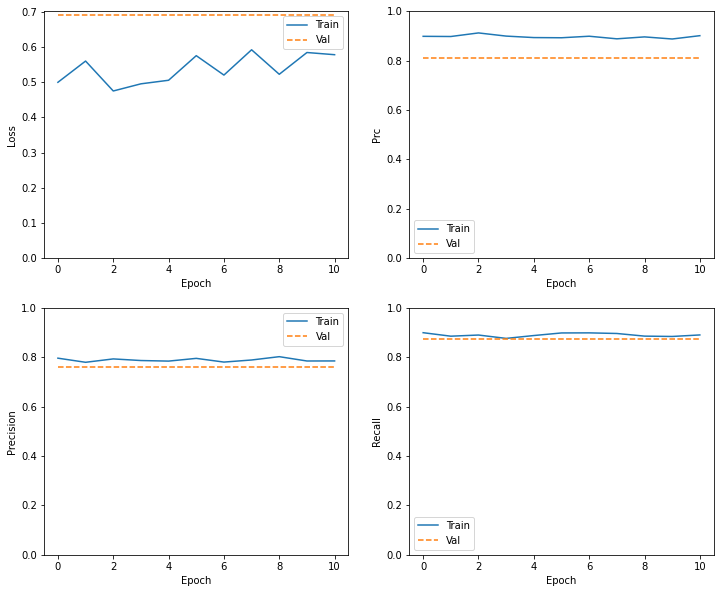

In [22]:
plot_metrics(transfer_history)

### Evaluate metrics

In [23]:
train_predictions_transfer = model.predict(train_generator, batch_size=batch_size,verbose=1)
valid_predictions_transfer = model.predict(valid_generator, batch_size=batch_size,verbose=1)
test_predictions_transfer = model.predict(test_generator, batch_size=test_generator.samples, verbose=1)

660/660 [==============================] - 403s 610ms/step


In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    # show numbers
    sns.heatmap(cm, annot=True, fmt="d", ax=ax[0])
    ax[0].set_title('Confusion matrix @{:.2f}'.format(p))
    ax[0].set_ylabel('Actual label')
    ax[0].set_xlabel('Predicted label')
    # show %
    cmp = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cmp, annot=True, fmt=".3f", 
                xticklabels=[f"pred_{c}" for c in train_generator.class_indices], 
                yticklabels=[f"true_{c}" for c in train_generator.class_indices],
                cmap="Blues",
                ax=ax[1])
    ax[1].set_title('Confusion matrix @{:.2f}'.format(p))
    ax[1].set_ylabel('Actual')
    ax[1].set_xlabel('Predicted')

    print('Legitimate Benign Detected (True Negatives): ', cm[0][0])
    print('Fraudulent Benign Incorrectly Detected (False Positives): ', cm[0][1])
    print('Legitimate Malignant Detected (True Positives): ', cm[1][1])
    print('Fraudulent Malignant Incorrectly Detected (False Negatives): ', cm[1][0])
    print('Total Incorrectly Detected: ', np.sum(cm[0][1]+cm[1][0]),' out of ',np.sum(cm))

20/20 [==============================] - 384s 19s/step - loss: 0.6904 - tp: 244.0000 - fp: 77.0000 - tn: 283.0000 - fn: 36.0000 - accuracy: 0.8234 - precision: 0.7601 - recall: 0.8714 - auc: 0.8882 - prc: 0.8111    
loss :  0.6904128789901733
tp :  244.0
fp :  77.0
tn :  283.0
fn :  36.0
accuracy :  0.823437511920929
precision :  0.7601246237754822
recall :  0.8714285492897034
auc :  0.888224184513092
prc :  0.8110625743865967

Legitimate Benign Detected (True Negatives):  274
Fraudulent Benign Incorrectly Detected (False Positives):  86
Legitimate Malignant Detected (True Positives):  282
Fraudulent Malignant Incorrectly Detected (False Negatives):  18
Total Incorrectly Detected:  104  out of  660


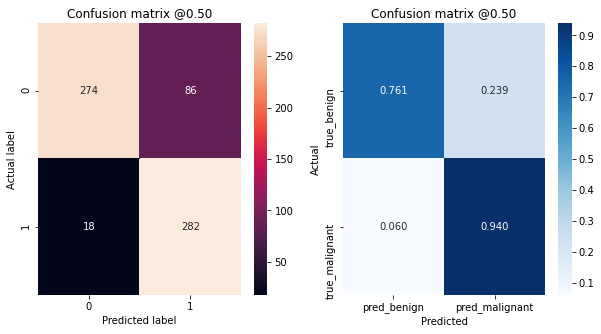

In [25]:
transfer_results = model.evaluate(valid_generator, steps=valid_generator.samples // batch_size, verbose=1)

for name, value in zip(model.metrics_names, transfer_results):
    print(name, ': ', value)
print()
plot_confusion_matrix(test_generator.labels, test_predictions_transfer, 0.5)

### Plot the ROC

In [26]:
from sklearn.metrics import roc_curve, auc

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    roc_auc = auc(fp, tp)
    plt.plot(100*fp, 100*tp, label=name+' (area = %0.2f)' % roc_auc, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
#     plt.xlim([-0.5,20])
#     plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

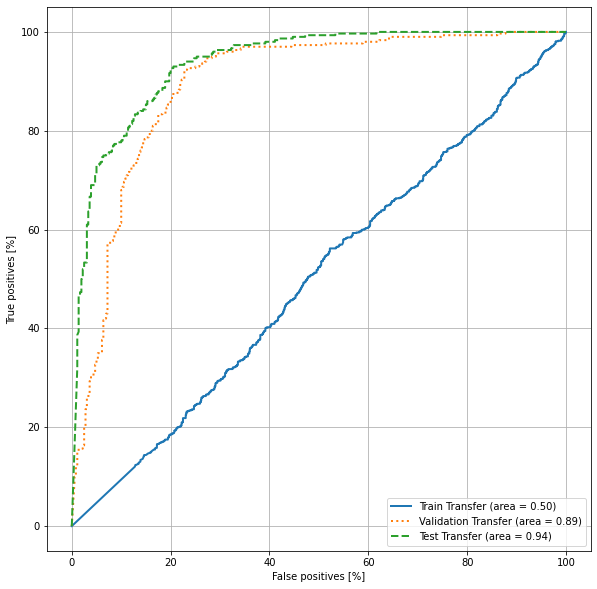

In [27]:
plot_roc("Train Transfer", train_generator.labels, train_predictions_transfer, color=colors[0])
plot_roc("Validation Transfer", valid_generator.labels, valid_predictions_transfer, color=colors[1], linestyle='dotted')
plot_roc("Test Transfer", test_generator.labels, test_predictions_transfer, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

### Plot the PRC

In [28]:
from sklearn.metrics import precision_recall_curve

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

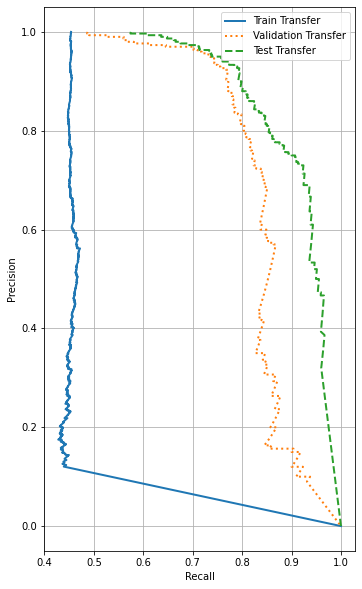

In [29]:
plot_prc("Train Transfer", train_generator.labels, train_predictions_transfer, color=colors[0])
plot_prc("Validation Transfer", valid_generator.labels, valid_predictions_transfer, color=colors[1], linestyle='dotted')
plot_prc("Test Transfer", test_generator.labels, test_predictions_transfer, color=colors[2], linestyle='--')
plt.legend(loc='upper right')

### Classification Report

In [30]:
from sklearn.metrics import classification_report

def show_classification_report(labels, predictions, p=0.5, **kwargs):
    print(classification_report(labels, predictions > p, **kwargs))

In [32]:
show_classification_report(test_generator.labels,test_predictions_transfer,p=0.5,target_names=['benign','malignant'])

              precision    recall  f1-score   support

      benign       0.94      0.76      0.84       360
   malignant       0.77      0.94      0.84       300

    accuracy                           0.84       660
   macro avg       0.85      0.85      0.84       660
weighted avg       0.86      0.84      0.84       660

